<a href="https://colab.research.google.com/github/vksyr/IST718/blob/master/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd  # data frame operations
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
import math

from pandas import Series
from statistics import mean
from statistics import median
from math import sqrt

from matplotlib import pyplot

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

#!pip install fbprophet
from fbprophet import Prophet

Import data

In [0]:
# zillow
homes = pd.read_csv('https://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv', encoding='latin_1')


In [61]:
homes.shape # (30434, 292)
len(homes['RegionName'].unique()) # 30,434 zip codes, one for each row.

30434

Arkansas Metro area analysis

In [0]:
ar_homes = homes[homes.State=='AR']

df = pd.DataFrame()
def getMetroAvg(cityName, col):
  global df
  city_homes = ar_homes.loc[ar_homes.City==cityName, col]
  avg = mean(city_homes[~np.isnan( city_homes)])
  df = df.append({'Date':date, 'Avg':avg, 'City':cityName}, ignore_index=True )

for col in ar_homes.columns: 
    date = pd.to_datetime(col, format='%Y-%m', errors='coerce')
    if(date >= pd.to_datetime('01-01-2017')):
      # get metro averages
      getMetroAvg('Hot Springs', col)  
      getMetroAvg('Little Rock', col)  
      getMetroAvg('Fayetteville', col)  
      getMetroAvg('Searcy', col)  

df = df.set_index('Date')
#df.iloc[0]

# Plot
groups = df.groupby(pd.Grouper('City'))
groups.plot(subplots=False, figsize=(15, 4)); 

Predicting avg median housing value by zip code in 2018

In [0]:
# Transpose and make series

df = homes.transpose()

# row names
df.insert(0, 'Date', df.index.values)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m', errors='coerce')

# col names
zips = df.iloc[1]
cols = ['zip_{0}'.format(z) for z in zips]
cols[0] = 'Date'
df.columns = cols

# drop additional info
df = df.drop('RegionID')
df = df.drop('City')
df = df.drop('State')
df = df.drop('Metro')
df = df.drop('CountyName')
df = df.drop('RegionName')
df = df.drop('SizeRank')

# make time series
df = df.set_index('Date')

# create avg column
df['zip_median'] = df.median(axis=1)

TypeError: ignored

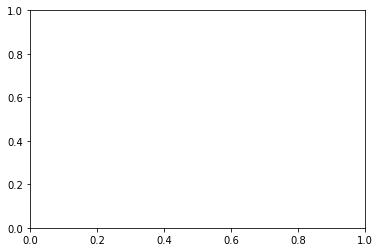

In [92]:
# Is stationary? Visualize. 
df['zip_median'].plot() # Dont see seasonality.

In [144]:
# Is stationary? Run AD FUller -> NO, p-value > .05
X = df['zip_median'].values
X = X.astype('float32')

result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.356649
p-value: 0.602874
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


In [145]:
# Get fuller p-values for different lags

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# Make stationary
X = df['zip_median'].values
X = X.astype('float32')

# difference data

for p in range(0, 40):
  lags = p
  stationary = difference(X, lags)
  result = adfuller(stationary)
  if result[1] < .05:
    print('lags: ' + str(p) + ', p-value: ' + str(result[1]))

#lags: 1, p-value: 0.016


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


lags: 1, p-value: 0.00227968705669878


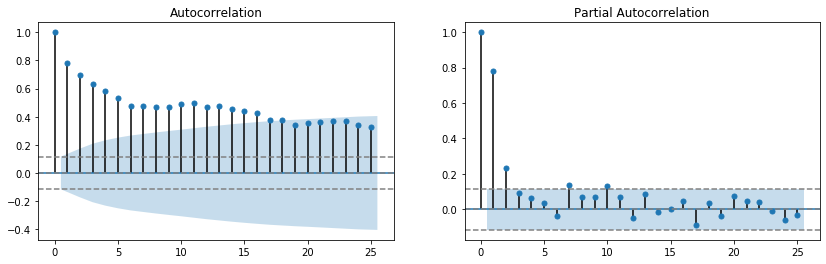

In [162]:
# make stationary with lag = 1, as discovered to be best with AD Fuller test
lags = 1
stationary = difference(X, lags)
stationary.index = df.index[lags:]

# USING STATIONARY TIME SERIES LOOK FOR ACF & PACF
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
fig = plot_acf(stationary, ax=ax1)
ax1.axhline(y=0,linestyle='--',color= 'gray')
ax1.axhline(y= - 1.96/np.sqrt(len(stationary)), linestyle='--',color= 'gray')
ax1.axhline(y=  1.96/np.sqrt(len(stationary)), linestyle='--',color= 'gray')
ax1.set_label('Lags')

fig = plot_pacf(stationary, ax=ax2)
ax2.axhline(y=0,linestyle = '--', color = 'gray')
ax2.axhline(y = -1.96/np.sqrt(len(stationary)), linestyle = '--', color = 'gray')
ax2.axhline(y = 1.96/np.sqrt(len(stationary)), linestyle = '--', color = 'gray')
ax2.set_label('Lags')




In [0]:
# BEST ARIMA params
# CODE RUNS LONG FOR EVALUATION - approximately 
import warnings

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.70)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		lags = 1 # best value discovered with fuller test above
		diff = difference(history, lags)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, lags)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)

warnings.filterwarnings("ignore")
evaluate_models(df['zip_median'].values, p_values, d_values, q_values)

# Best: ARIMA(6, 1, 0) RMSE=139.733

Make predictions

In [0]:
# backwards fill for nan values
df = df.fillna(method='bfill')
#homes = homes.fillna(method='ffill')

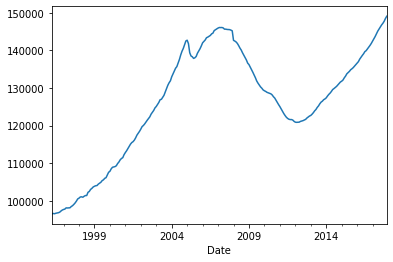

In [183]:
homes_before2018.plot()

In [0]:
# get training data (1997-2017) and test data (2018)

homes_before2018 = df['zip_median'].loc[:'2017']
homes_2018 = df['zip_median'].loc['2018']
train = homes_before2018.values.astype('float32')
test = homes_2018.values.astype('float32')

history = [x for x in train]

#cutoff = round(X.size * .8)
#train = X[:cutoff]
#test = X[cutoff+1:]

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# make predictions
predictions = list()

for i in range(len(test)):
	
	lags = 1
	diff = difference(history, lags) 	# difference data
	model = ARIMA(diff, order=(6,1,0)) # best p,d, & q values discovered from the loop above
	model_fit = model.fit(trend='nc', disp=0)

	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, lags)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	#print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

RMSE: 157.754


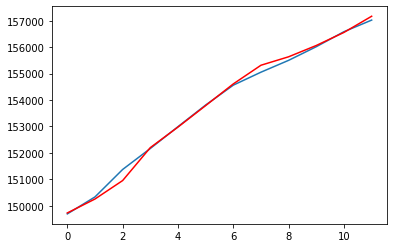

In [149]:
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

                0
count   12.000000
mean   -11.894349
std    164.299917
min   -262.771496
25%    -68.563637
50%    -34.612341
75%     22.644788
max    419.547661


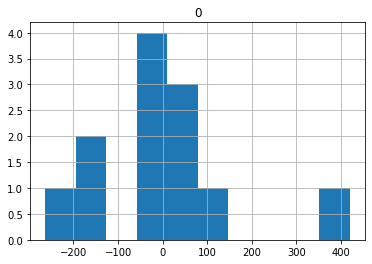

In [114]:
# residuals
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot
residuals.hist(ax=pyplot.gca())
pyplot.show()

# mean: -11.894349

In [0]:
# Make new predictions with mean residual as bias
bias = -11.894349
predictions = list()

for i in range(len(test)):
	
	lags = 1
	diff = difference(history, lags) 	# difference data
	model = ARIMA(diff, order=(6,1,0)) # best p,d, & q values discovered from the loop above
	model_fit = model.fit(trend='nc', disp=0)

	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, lags)

	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	#print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

RMSE: 3047.263


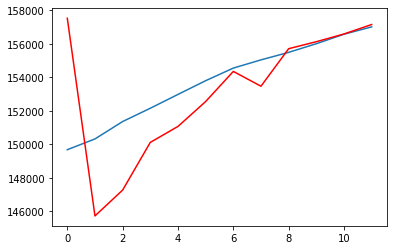

In [116]:
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


# not as good

Dept of Labor Employment Dataset

In [0]:
# DOL Employment
# https://beta.bls.gov/dataViewer/view/timeseries/CES0000000001;jsessionid=542AB1B7EFC43613AD715045DF37B0B6
employ = pd.read_csv('/content/DOL_empl.csv')
employ = employ[3:]  # remove first 3 months not in the main housing dataset

In [0]:
# merge employment data to main df
df['Natl_empl'] = list(employ['Value'])

In [0]:
# SARIMAX Model

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# test/training data
train = df.loc[:'2017']
test = df.loc['2018']  

history = [x for x in train['zip_median']]

# make predictions
predictions = list()
lags = 1

for i in range(len(test)):

  # make new series to make new model.
  diff_series = pd.DataFrame()
  diff_series['zip_median_diff'] = difference(history, lags) # difference data
  diff_series.index = df[1:len(diff_series)+1].index

  # make new model
  model = sm.tsa.statespace.SARIMAX(endog = diff_series['zip_median_diff'],
    exog = df['Natl_empl'][1:len(history)],  
    trend='t',  # ‘n’,’c’,’t’, or ’ct’
    order=(6,1,0)
  )
  
  model_fit = model.fit()

  # predict and then add single prediction to history
  yhat = model_fit.predict(start = pd.to_datetime('2018-01'), end = pd.to_datetime('2018-12'),
    exog = pd.DataFrame(test['Natl_empl'][i:]), 
    dynamic= True)[i]

  yhat = inverse_difference(history, yhat, lags)

  predictions.append(yhat)
  # observation
  obs = test['zip_median'].iloc[i]

  history.append(obs)
  # should we be saving the test obs or predicted obs to train the model for
  # the next prediction

In [0]:
# report performance
mse = mean_squared_error(test['zip_median'].values, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

# SARIMAX (6, 1, 0), trend = 'n', w/ exog  --> RMSE: 192.517
# SARIMAX (6, 1, 0), trend = 'c', w/ exog  --> RMSE: 192.517
# SARIMAX (6, 1, 0), trend = 'ct', w/ exog --> RMSE: 193.963
# SARIMAX (6, 1, 0), trend = 't', w/ exog  --> RMSE: 188.584, no exog: RMSE: 188.673

# plot
pyplot.plot(test['zip_median'].values)
pyplot.plot(predictions, color='red')
pyplot.show()

Prophet

In [0]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)
my_model.fit(df)

Forecast

In [0]:
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=5)[0]

wk = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, 52)
	print('Week %d: %f' % (wk, inverted))
	history.append(inverted)
	wk += 1

Week 1: 45.990899
Week 2: 46.205453
Week 3: 45.903572
Week 4: 46.135158
Week 5: 45.980117
